In [ ]:
# PLACE ALL IMPORTS HERE
import pandas as pd
import sys
from google.colab import drive
import sklearn
import sklearn.impute, sklearn.pipeline
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
import sklearn.metrics as metrics
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

from sklearn.model_selection import GridSearchCV


from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score

from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns

# Initialization

In [ ]:
# MOUNT YOUR GOOGLE DRIVE 
# (It only mounts to your private Virtual Machine, it doesn't expose your drive to anyone else)
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
# LOAD THE FILE
df = pd.read_csv("/content/drive/My Drive/Data Mining Project - Share/Data/combined.csv")
# Converting the column to DateTime format
df.Date = pd.to_datetime(df.Date, format='%Y-%m-%d')
df = df.set_index('Date')
df.head()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (18,39,42,44,45,46,47,48,49) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,year,month,day,statefips,freq,spend_acf,spend_aer,spend_all,spend_apg,spend_grf,spend_hcs,spend_tws,spend_all_inchigh,spend_all_inclow,spend_all_incmiddle,spend_retail_w_grocery,spend_retail_no_grocery,provisional,revenue_all,revenue_ss40,revenue_ss60,revenue_ss65,revenue_ss70,merchants_all,merchants_ss40,merchants_ss60,merchants_ss65,merchants_ss70,emp_combined,emp_combined_inclow,emp_combined_incmiddle,emp_combined_inchigh,emp_combined_ss40,emp_combined_ss60,emp_combined_ss65,emp_combined_ss70,case_count,death_count,test_count,case_rate,death_rate,test_rate,new_positives_rate,new_case_rate,new_death_rate,new_test_rate,new_case_count,new_death_count,new_test_count,initclaims_count_regular,initclaims_rate_regular,contclaims_count_regular,contclaims_rate_regular,initclaims_count_pua,contclaims_count_pua,contclaims_count_peuc,initclaims_rate_pua,contclaims_rate_pua,contclaims_rate_peuc,initclaims_count_combined,contclaims_count_combined,initclaims_rate_combined,contclaims_rate_combined,bg_posts,bg_posts_ss30,bg_posts_ss55,bg_posts_ss60,bg_posts_ss65,bg_posts_ss70,bg_posts_jz1,bg_posts_jzgrp12,bg_posts_jz2,bg_posts_jz3,bg_posts_jzgrp345,bg_posts_jz4,bg_posts_jz5
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-01-01,2020,1,1,1,d,.,.,.,.,.,.,.,.,.,.,.,.,0,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,0,0,.,0.0,0.0,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.
2020-01-01,2020,1,1,2,d,.,.,.,.,.,.,.,.,.,.,.,.,0,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,0,0,.,0.0,0.0,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.
2020-01-01,2020,1,1,4,d,.,.,.,.,.,.,.,.,.,.,.,.,0,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,0,0,.,0.0,0.0,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.
2020-01-01,2020,1,1,5,d,.,.,.,.,.,.,.,.,.,.,.,.,0,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,0,0,.,0.0,0.0,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.
2020-01-01,2020,1,1,6,d,.,.,.,.,.,.,.,.,.,.,.,.,0,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,0,0,.,0.0,0.0,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.


In [ ]:
# Convert to numerical values
for col in df.columns:
  if (col != "freq"):
    df[col] = pd.to_numeric(df[col], errors="coerce")

display(df.head())

,year,month,day,statefips,freq,spend_acf,spend_aer,spend_all,spend_apg,spend_grf,spend_hcs,spend_tws,spend_all_inchigh,spend_all_inclow,spend_all_incmiddle,spend_retail_w_grocery,spend_retail_no_grocery,provisional,revenue_all,revenue_ss40,revenue_ss60,revenue_ss65,revenue_ss70,merchants_all,merchants_ss40,merchants_ss60,merchants_ss65,merchants_ss70,emp_combined,emp_combined_inclow,emp_combined_incmiddle,emp_combined_inchigh,emp_combined_ss40,emp_combined_ss60,emp_combined_ss65,emp_combined_ss70,case_count,death_count,test_count,case_rate,death_rate,test_rate,new_positives_rate,new_case_rate,new_death_rate,new_test_rate,new_case_count,new_death_count,new_test_count,initclaims_count_regular,initclaims_rate_regular,contclaims_count_regular,contclaims_rate_regular,initclaims_count_pua,contclaims_count_pua,contclaims_count_peuc,initclaims_rate_pua,contclaims_rate_pua,contclaims_rate_peuc,initclaims_count_combined,contclaims_count_combined,initclaims_rate_combined,contclaims_rate_combined,bg_posts,bg_posts_ss30,bg_posts_ss55,bg_posts_ss60,bg_posts_ss65,bg_posts_ss70,bg_posts_jz1,bg_posts_jzgrp12,bg_posts_jz2,bg_posts_jz3,bg_posts_jzgrp345,bg_posts_jz4,bg_posts_jz5
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-01-01,2020,1,1,1,d,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01,2020,1,1,2,d,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01,2020,1,1,4,d,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01,2020,1,1,5,d,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01,2020,1,1,6,d,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Exploratory Data Analysis

In [ ]:
#display(df.info())
#pd.value_counts(df["freq"])
#display(df[df["freq"]=="."])
display(df)

print("First valid Spend ACF:",df["spend_acf"].first_valid_index())
print("First valid Test:", df["test_count"].first_valid_index())
print("First valid bg_posts:", df["bg_posts"].first_valid_index())

,year,month,day,statefips,freq,spend_acf,spend_aer,spend_all,spend_apg,spend_grf,spend_hcs,spend_tws,spend_all_inchigh,spend_all_inclow,spend_all_incmiddle,spend_retail_w_grocery,spend_retail_no_grocery,provisional,revenue_all,revenue_ss40,revenue_ss60,revenue_ss65,revenue_ss70,merchants_all,merchants_ss40,merchants_ss60,merchants_ss65,merchants_ss70,emp_combined,emp_combined_inclow,emp_combined_incmiddle,emp_combined_inchigh,emp_combined_ss40,emp_combined_ss60,emp_combined_ss65,emp_combined_ss70,case_count,death_count,test_count,case_rate,death_rate,test_rate,new_positives_rate,new_case_rate,new_death_rate,new_test_rate,new_case_count,new_death_count,new_test_count,initclaims_count_regular,initclaims_rate_regular,contclaims_count_regular,contclaims_rate_regular,initclaims_count_pua,contclaims_count_pua,contclaims_count_peuc,initclaims_rate_pua,contclaims_rate_pua,contclaims_rate_peuc,initclaims_count_combined,contclaims_count_combined,initclaims_rate_combined,contclaims_rate_combined,bg_posts,bg_posts_ss30,bg_posts_ss55,bg_posts_ss60,bg_posts_ss65,bg_posts_ss70,bg_posts_jz1,bg_posts_jzgrp12,bg_posts_jz2,bg_posts_jz3,bg_posts_jzgrp345,bg_posts_jz4,bg_posts_jz5
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-01-01,2020,1,1,1,d,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01,2020,1,1,2,d,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01,2020,1,1,4,d,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01,2020,1,1,5,d,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01,2020,1,1,6,d,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-05,2020,11,5,51,.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,187202,3688,2733990.0,2193.0,43.2,32031.0,0.0726,15.1,0.087,230.0,1288.0,7.43,19627.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-11-05,2020,11,5,53,.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,118459,2542,2519494.0,1556.0,33.4,33086.0,0.0562,14.5,0.148,255.0,1102.0,11.30,19452.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-11-05,2020,11,5,54,.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26547,480,817092.0,1481.0,26.8,45593.0,0.0515,24.6,0.295,458.0,440.0,5.29

First valid Spend ACF: 2020-01-13 00:00:00
First valid Test: 2020-01-22 00:00:00
First valid bg_posts: 2020-01-10 00:00:00


# Preprocessing

## Filtering

In [ ]:
# DO PREPROCESSING

# Drop January and November
df_simple = df[df["month"].gt(1) & df["month"].lt(11)].copy()
# Drop cumulative COVID data (better to use rates/new counts)
#df_simple.drop(["case_count", "death_count", "test_count"], axis=1, inplace=True)

#df_simple['date'] = pd.to_datetime(df_simple[['year','month','day']])

#df_simple.shape
df_simple.head()

,year,month,day,statefips,freq,spend_acf,spend_aer,spend_all,spend_apg,spend_grf,spend_hcs,spend_tws,spend_all_inchigh,spend_all_inclow,spend_all_incmiddle,spend_retail_w_grocery,spend_retail_no_grocery,provisional,revenue_all,revenue_ss40,revenue_ss60,revenue_ss65,revenue_ss70,merchants_all,merchants_ss40,merchants_ss60,merchants_ss65,merchants_ss70,emp_combined,emp_combined_inclow,emp_combined_incmiddle,emp_combined_inchigh,emp_combined_ss40,emp_combined_ss60,emp_combined_ss65,emp_combined_ss70,case_count,death_count,test_count,case_rate,death_rate,test_rate,new_positives_rate,new_case_rate,new_death_rate,new_test_rate,new_case_count,new_death_count,new_test_count,initclaims_count_regular,initclaims_rate_regular,contclaims_count_regular,contclaims_rate_regular,initclaims_count_pua,contclaims_count_pua,contclaims_count_peuc,initclaims_rate_pua,contclaims_rate_pua,contclaims_rate_peuc,initclaims_count_combined,contclaims_count_combined,initclaims_rate_combined,contclaims_rate_combined,bg_posts,bg_posts_ss30,bg_posts_ss55,bg_posts_ss60,bg_posts_ss65,bg_posts_ss70,bg_posts_jz1,bg_posts_jzgrp12,bg_posts_jz2,bg_posts_jz3,bg_posts_jzgrp345,bg_posts_jz4,bg_posts_jz5
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-02-01,2020,2,1,1,d,0.010200,-0.10200,-0.0261,-0.000159,-0.00956,0.008790,-0.00416,-0.0293,-0.0258,-0.02700,-0.00678,-0.00478,0.0,-0.0211,-0.02430,-0.00398,-0.0258,-0.00287,0.012000,0.00773,0.000303,0.03300,0.00720,0.005810,0.000862,0.01300,-0.00192,-0.00402,-0.00257,0.00757,0.00314,0,0,NaN,0.00000,0.0,NaN,NaN,0.000000,0.0,NaN,0.000,0.0,NaN,2170.0,0.0968,17284.0,0.771,0.0,0.0,0.0,0.0,0.0,0.0,2170.0,17284.0,0.0968,0.771,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-01,2020,2,1,2,d,0.140000,-0.14700,0.0265,0.038900,0.06000,-0.265000,0.10200,0.0169,NaN,0.07820,0.08580,0.09720,0.0,-0.0889,-0.03990,-0.07910,-0.4130,-0.03180,-0.023500,-0.04630,-0.056000,-0.00588,-0.01670,0.000821,-0.034700,0.00512,0.00345,-0.03080,-0.00493,0.02620,-0.01040,0,0,NaN,0.00000,0.0,NaN,NaN,0.000000,0.0,NaN,0.000,0.0,NaN,1122.0,0.3230,9579.0,2.750,0.0,0.0,0.0,0.0,0.0,0.0,1122.0,9579.0,0.3230,2.750,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-01,2020,2,1,4,d,0.014300,0.03390,0.0109,0.049500,0.04140,0.002390,-0.02570,0.0292,0.0257,-0.00371,0.03740,0.03510,0.0,-0.0333,-0.01110,0.05630,-0.0772,-0.04070,-0.005150,-0.00581,-0.003890,-0.00931,-0.00540,0.009640,0.001150,0.01310,0.01100,0.00263,0.00712,0.00956,0.01060,1,0,NaN,0.01370,0.0,NaN,NaN,0.001960,0.0,NaN,0.143,0.0,NaN,3807.0,0.1070,18854.0,0.531,0.0,0.0,0.0,0.0,0.0,0.0,3807.0,18854.0,0.1070,0.531,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-01,2020,2,1,5,d,-0.000614,0.05180,0.0321,0.082300,0.03120,0.000837,-0.02560,0.1830,0.0527,0.01080,0.03920,0.04580,0.0,-0.0488,0.00923,-0.08170,-0.0260,0.00344,-0.000437,-0.00251,-0.033500,-0.00814,0.00579,0.005490,0.008750,0.00828,NaN,-0.00762,0.01320,NaN,0.03010,0,0,NaN,0.00000,0.0,NaN,NaN,0.000000,0.0,NaN,0.000,0.0,NaN,1837.0,0.1350,13210.0,0.969,0.0,0.0,0.0,0.0,0.0,0.0,1837.0,13210.0,0.1350,0.969,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-01,2020,2,1,6,d,0.008510,0.00176,-0.0107,0.017200,0.01340,-0.023700,-0.00323,-0.0135,-0.0109,-0.00532,0.00249,-0.00126,0.0,-0.0342,-0.01510,-0.05200,-0.0755,-0.02620,-0.007420,-0.00757,-0.018300,-0.00621,-0.00631,0.011000,-0.012600,0.01610,0.01030,0.00511,0.00899,0.01610,0.01490,3,0,NaN,0.00759,0.0,NaN,NaN,0.000723,0.0,NaN,0.286,0.0,NaN,43458.0,0.2240,388341.0,2.000,0.0,0.0,0.0,0.0,0.0,0.0,43458.0,388341.0,0.2240,2.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Imputing/Filling

Stategy: Don't use Simple Imputer, which takes the mean/median/mode/etc. across all records in a feature. This would lose the time sensitive data. Here we are using "method = time" for imputation. Feel free to change it to linear if you want or anything else and test it

In [ ]:

# First fill COVID data
covid_ids = ["death", "case", "test", "positives"]
# If March or earlier, fill NAs with zero
for col in df_simple.columns:
  for covid_id in covid_ids:
    if covid_id in col:
      df_simple.loc[df_simple["month"]<=3, col] = df_simple.loc[df_simple["month"]<=3, col].fillna(0, inplace=False)
      # Also force all to be >= 0
      df_simple.loc[:, col] = df_simple.loc[:, col].clip(lower=0, inplace=False)
      #df_simple.loc[col, df_simple[col].isna()] = 0


#df_simple = df_simple.drop(['year','month','day','freq'],axis=1)
## Impute the DATA
count = df_simple.isna().sum()
print(count)
df_simple = df_simple.interpolate(method = 'time')

#df_slinear = df_simple.assign(InterpolateSLinear=df_simple.target.interpolate(method='slinear'))
count_2 = df_simple.isna().sum()
print(count_2)

year                     0
month                    0
day                      0
statefips                0
freq                     0
                     ...  
bg_posts_jz2         11985
bg_posts_jz3         11985
bg_posts_jzgrp345    11985
bg_posts_jz4         11985
bg_posts_jz5         11985
Length: 76, dtype: int64
year                   0
month                  0
day                    0
statefips              0
freq                   0
                    ... 
bg_posts_jz2         306
bg_posts_jz3         306
bg_posts_jzgrp345    306
bg_posts_jz4         306
bg_posts_jz5         306
Length: 76, dtype: int64


In [ ]:
## This is just a function used to get the covid delays, 
## just pass to it a delay vector and it can delay the covid data by any element in the vector
def df_derived_by_shift(df,lag=0):
    df = df.copy()
    if not lag:
        return df
    cols ={}
    for i in lag:
        for x in list(df.columns):
                if not x in cols:
                    cols[x] = ['{}_{}'.format(x, i)]
                else:
                    cols[x].append('{}_{}'.format(x, i))
    for k,v in cols.items():
        columns = v
        dfn = pd.DataFrame(data=None, columns=columns, index=df.index)    
        i = 0
        for c in columns:
            dfn[c] = df[k].shift(periods=lag[i]*51) ## this is because we want to shift all the 51 states
            i = i+1
        df = pd.concat([df, dfn], axis=1)
    return df

In [ ]:
covid_columns = ["case_rate", 	
                 "death_rate", 	
                 "test_rate", 	
                 "new_positives_rate",
                 "new_case_rate", 	
                 "new_death_rate", 	
                 "new_test_rate", 	
                 "new_case_count", 	
                 "new_death_count", 	
                 "new_test_count"]

states = ["statefips"]  

spending_columns = ["spend_acf",	"spend_aer",	"spend_all",	"spend_apg",	"spend_grf",	"spend_hcs","spend_tws",
                    "spend_all_inchigh",	"spend_all_inclow",	"spend_all_incmiddle"]

revenues_columns = ["revenue_all",	"revenue_ss40",	"revenue_ss60",	"revenue_ss65",
                    "revenue_ss70",	"merchants_all",	"merchants_ss40",	"merchants_ss60",	"merchants_ss65",	"merchants_ss70"]

employment_columns = ["emp_combined",	"emp_combined_inclow",	"emp_combined_incmiddle", "emp_combined_inchigh",	"emp_combined_ss40",	"emp_combined_ss60",
                      "emp_combined_ss65",	"emp_combined_ss70","initclaims_count_regular",	"initclaims_rate_regular",	"contclaims_count_regular",	
                      "contclaims_rate_regular",	"initclaims_count_pua",	"contclaims_count_pua",	"contclaims_count_peuc",	"initclaims_rate_pua",
                      "contclaims_rate_pua",	"contclaims_rate_peuc","initclaims_count_combined",	"contclaims_count_combined",	"initclaims_rate_combined",
                      "contclaims_rate_combined",	"bg_posts","bg_posts_ss30",	"bg_posts_ss55",	"bg_posts_ss60",	"bg_posts_ss65",	"bg_posts_ss70",
                      "bg_posts_jz1",	"bg_posts_jzgrp12","bg_posts_jz2","bg_posts_jz3",	"bg_posts_jzgrp345",	"bg_posts_jz4",	"bg_posts_jz5"]


# df_simple["days_since_2020Feb01"] = (df_simple["date"] - pd.to_datetime("2020-02-01")).dt.days
# df_simple = df_simple.set_index(["date", "statefips"])

# df_econ = df_simple.drop(["year", "month", "day", "freq"], axis=1).drop(covid_columns, axis=1)
# keep = ["statefips"]
# keep.extend(covid_columns)
# keep.append("days_since_2020Feb01")

df_covid = df_simple.filter(covid_columns, axis=1)
df_states = df_simple.filter(states, axis=1)
df_spending = df_simple.filter(spending_columns, axis=1)
df_revenues = df_simple.filter(revenues_columns, axis=1)
df_employment = df_simple.filter(employment_columns, axis=1)

econ_frames = [df_spending, df_revenues,df_employment]
df_econ = pd.concat(econ_frames,axis=1)

display(df_econ.head())
display(df_covid.head())

,spend_acf,spend_aer,spend_all,spend_apg,spend_grf,spend_hcs,spend_tws,spend_all_inchigh,spend_all_inclow,spend_all_incmiddle,revenue_all,revenue_ss40,revenue_ss60,revenue_ss65,revenue_ss70,merchants_all,merchants_ss40,merchants_ss60,merchants_ss65,merchants_ss70,emp_combined,emp_combined_inclow,emp_combined_incmiddle,emp_combined_inchigh,emp_combined_ss40,emp_combined_ss60,emp_combined_ss65,emp_combined_ss70,initclaims_count_regular,initclaims_rate_regular,contclaims_count_regular,contclaims_rate_regular,initclaims_count_pua,contclaims_count_pua,contclaims_count_peuc,initclaims_rate_pua,contclaims_rate_pua,contclaims_rate_peuc,initclaims_count_combined,contclaims_count_combined,initclaims_rate_combined,contclaims_rate_combined,bg_posts,bg_posts_ss30,bg_posts_ss55,bg_posts_ss60,bg_posts_ss65,bg_posts_ss70,bg_posts_jz1,bg_posts_jzgrp12,bg_posts_jz2,bg_posts_jz3,bg_posts_jzgrp345,bg_posts_jz4,bg_posts_jz5
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-02-01,0.010200,-0.10200,-0.0261,-0.000159,-0.00956,0.008790,-0.00416,-0.0293,-0.0258,-0.02700,-0.0211,-0.02430,-0.00398,-0.0258,-0.00287,0.012000,0.00773,0.000303,0.03300,0.00720,0.005810,0.000862,0.01300,-0.00192,-0.00402,-0.00257,0.00757,0.00314,2170.0,0.0968,17284.0,0.771,0.0,0.0,0.0,0.0,0.0,0.0,2170.0,17284.0,0.0968,0.771,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-01,0.140000,-0.14700,0.0265,0.038900,0.06000,-0.265000,0.10200,0.0169,0.0498,0.07820,-0.0889,-0.03990,-0.07910,-0.4130,-0.03180,-0.023500,-0.04630,-0.056000,-0.00588,-0.01670,0.000821,-0.034700,0.00512,0.00345,-0.03080,-0.00493,0.02620,-0.01040,1122.0,0.3230,9579.0,2.750,0.0,0.0,0.0,0.0,0.0,0.0,1122.0,9579.0,0.3230,2.750,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-01,0.014300,0.03390,0.0109,0.049500,0.04140,0.002390,-0.02570,0.0292,0.0257,-0.00371,-0.0333,-0.01110,0.05630,-0.0772,-0.04070,-0.005150,-0.00581,-0.003890,-0.00931,-0.00540,0.009640,0.001150,0.01310,0.01100,0.00263,0.00712,0.00956,0.01060,3807.0,0.1070,18854.0,0.531,0.0,0.0,0.0,0.0,0.0,0.0,3807.0,18854.0,0.1070,0.531,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-01,-0.000614,0.05180,0.0321,0.082300,0.03120,0.000837,-0.02560,0.1830,0.0527,0.01080,-0.0488,0.00923,-0.08170,-0.0260,0.00344,-0.000437,-0.00251,-0.033500,-0.00814,0.00579,0.005490,0.008750,0.00828,-0.00377,-0.00762,0.01320,0.00756,0.03010,1837.0,0.1350,13210.0,0.969,0.0,0.0,0.0,0.0,0.0,0.0,1837.0,13210.0,0.1350,0.969,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-01,0.008510,0.00176,-0.0107,0.017200,0.01340,-0.023700,-0.00323,-0.0135,-0.0109,-0.00532,-0.0342,-0.01510,-0.05200,-0.0755,-0.02620,-0.007420,-0.00757,-0.018300,-0.00621,-0.00631,0.011000,-0.012600,0.01610,0.01030,0.00511,0.00899,0.01610,0.01490,43458.0,0.2240,388341.0,2.000,0.0,0.0,0.0,0.0,0.0,0.0,43458.0,388341.0,0.2240,2.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,case_rate,death_rate,test_rate,new_positives_rate,new_case_rate,new_death_rate,new_test_rate,new_case_count,new_death_count,new_test_count
Date,,,,,,,,,,
2020-02-01,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000,0.0,0.0
2020-02-01,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000,0.0,0.0
2020-02-01,0.01370,0.0,0.0,0.0,0.001960,0.0,0.0,0.143,0.0,0.0
2020-02-01,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000,0.0,0.0
2020-02-01,0.00759,0.0,0.0,0.0,0.000723,0.0,0.0,0.286,0.0,0.0


In [ ]:
## This is where we use the previous function to delay the covid data which is already imputed

delay = [3,7,10]
delay_econ = [3]
#df_covid = df_derived_by_shift(df_covid, delay)
df_econ = df_derived_by_shift(df_econ, delay_econ)
## df_spending = df_derived_by_shift(df_spending, delay_spending)
display(df_econ.head())

,spend_acf,spend_aer,spend_all,spend_apg,spend_grf,spend_hcs,spend_tws,spend_all_inchigh,spend_all_inclow,spend_all_incmiddle,revenue_all,revenue_ss40,revenue_ss60,revenue_ss65,revenue_ss70,merchants_all,merchants_ss40,merchants_ss60,merchants_ss65,merchants_ss70,emp_combined,emp_combined_inclow,emp_combined_incmiddle,emp_combined_inchigh,emp_combined_ss40,emp_combined_ss60,emp_combined_ss65,emp_combined_ss70,initclaims_count_regular,initclaims_rate_regular,contclaims_count_regular,contclaims_rate_regular,initclaims_count_pua,contclaims_count_pua,contclaims_count_peuc,initclaims_rate_pua,contclaims_rate_pua,contclaims_rate_peuc,initclaims_count_combined,contclaims_count_combined,...,merchants_all_3,merchants_ss40_3,merchants_ss60_3,merchants_ss65_3,merchants_ss70_3,emp_combined_3,emp_combined_inclow_3,emp_combined_incmiddle_3,emp_combined_inchigh_3,emp_combined_ss40_3,emp_combined_ss60_3,emp_combined_ss65_3,emp_combined_ss70_3,initclaims_count_regular_3,initclaims_rate_regular_3,contclaims_count_regular_3,contclaims_rate_regular_3,initclaims_count_pua_3,contclaims_count_pua_3,contclaims_count_peuc_3,initclaims_rate_pua_3,contclaims_rate_pua_3,contclaims_rate_peuc_3,initclaims_count_combined_3,contclaims_count_combined_3,initclaims_rate_combined_3,contclaims_rate_combined_3,bg_posts_3,bg_posts_ss30_3,bg_posts_ss55_3,bg_posts_ss60_3,bg_posts_ss65_3,bg_posts_ss70_3,bg_posts_jz1_3,bg_posts_jzgrp12_3,bg_posts_jz2_3,bg_posts_jz3_3,bg_posts_jzgrp345_3,bg_posts_jz4_3,bg_posts_jz5_3
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-02-01,0.010200,-0.10200,-0.0261,-0.000159,-0.00956,0.008790,-0.00416,-0.0293,-0.0258,-0.02700,-0.0211,-0.02430,-0.00398,-0.0258,-0.00287,0.012000,0.00773,0.000303,0.03300,0.00720,0.005810,0.000862,0.01300,-0.00192,-0.00402,-0.00257,0.00757,0.00314,2170.0,0.0968,17284.0,0.771,0.0,0.0,0.0,0.0,0.0,0.0,2170.0,17284.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-01,0.140000,-0.14700,0.0265,0.038900,0.06000,-0.265000,0.10200,0.0169,0.0498,0.07820,-0.0889,-0.03990,-0.07910,-0.4130,-0.03180,-0.023500,-0.04630,-0.056000,-0.00588,-0.01670,0.000821,-0.034700,0.00512,0.00345,-0.03080,-0.00493,0.02620,-0.01040,1122.0,0.3230,9579.0,2.750,0.0,0.0,0.0,0.0,0.0,0.0,1122.0,9579.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-01,0.014300,0.03390,0.0109,0.049500,0.04140,0.002390,-0.02570,0.0292,0.0257,-0.00371,-0.0333,-0.01110,0.05630,-0.0772,-0.04070,-0.005150,-0.00581,-0.003890,-0.00931,-0.00540,0.009640,0.001150,0.01310,0.01100,0.00263,0.00712,0.00956,0.01060,3807.0,0.1070,18854.0,0.531,0.0,0.0,0.0,0.0,0.0,0.0,3807.0,18854.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-01,-0.000614,0.05180,0.0321,0.082300,0.03120,0.000837,-0.02560,0.1830,0.0527,0.01080,-0.0488,0.00923,-0.08170,-0.0260,0.00344,-0.000437,-0.00251,-0.033500,-0.00814,0.00579,0.005490,0.008750,0.00828,-0.00377,-0.00762,0.01320,0.00756,0.03010,1837.0,0.1350,13210.0,0.969,0.0,0.0,0.0,0.0,0.0,0.0,1837.0,13210.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-01,0.008510,0.00176,-0.0107,0.017200,0.01340,-0.023700,-0.00323,-0.0135,-0.0109,-0.00532,-0.0342,-0.01510,-0.05200,-0.0755,-0.02620,-0.007420,-0.00757,-0.018300,-0.00621,-0.00631,0.011000,-0.012600,0.01610,0.01030,0.00511,0.00899,0.01610,0.01490,43458.0,0.2240,388341.0,2.000,0.0,0.0,0.0,0.0,0.0,0.0,43458.0,388341.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_covid.to_csv('data.csv')
!cp data.csv "drive/My Drive/"

In [ ]:
## As you can see now we have NANs that arises from 2 things:
## 1- The imputation method won't fill all of them
## 2- Shifting the data will introduce NAN entries
## Let's remove all of the NAN entries now. I am appending the data again because we need all the data to have the same index
frames = [df_states, df_covid, df_econ]
df_new = pd.concat(frames,axis=1)
df_new = df_new.dropna()
display(df_new.head())

,statefips,case_rate,death_rate,test_rate,new_positives_rate,new_case_rate,new_death_rate,new_test_rate,new_case_count,new_death_count,new_test_count,spend_acf,spend_aer,spend_all,spend_apg,spend_grf,spend_hcs,spend_tws,spend_all_inchigh,spend_all_inclow,spend_all_incmiddle,revenue_all,revenue_ss40,revenue_ss60,revenue_ss65,revenue_ss70,merchants_all,merchants_ss40,merchants_ss60,merchants_ss65,merchants_ss70,emp_combined,emp_combined_inclow,emp_combined_incmiddle,emp_combined_inchigh,emp_combined_ss40,emp_combined_ss60,emp_combined_ss65,emp_combined_ss70,initclaims_count_regular,...,merchants_all_3,merchants_ss40_3,merchants_ss60_3,merchants_ss65_3,merchants_ss70_3,emp_combined_3,emp_combined_inclow_3,emp_combined_incmiddle_3,emp_combined_inchigh_3,emp_combined_ss40_3,emp_combined_ss60_3,emp_combined_ss65_3,emp_combined_ss70_3,initclaims_count_regular_3,initclaims_rate_regular_3,contclaims_count_regular_3,contclaims_rate_regular_3,initclaims_count_pua_3,contclaims_count_pua_3,contclaims_count_peuc_3,initclaims_rate_pua_3,contclaims_rate_pua_3,contclaims_rate_peuc_3,initclaims_count_combined_3,contclaims_count_combined_3,initclaims_rate_combined_3,contclaims_rate_combined_3,bg_posts_3,bg_posts_ss30_3,bg_posts_ss55_3,bg_posts_ss60_3,bg_posts_ss65_3,bg_posts_ss70_3,bg_posts_jz1_3,bg_posts_jzgrp12_3,bg_posts_jz2_3,bg_posts_jz3_3,bg_posts_jzgrp345_3,bg_posts_jz4_3,bg_posts_jz5_3
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-02-10,1,0.0000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000,0.0,0.0,-0.0142,0.0530,-0.00156,-0.08330,0.037500,-0.0477,-0.02940,-0.00325,0.00622,-0.01190,0.0668,0.0335,0.0680,0.1330,0.104,-0.03010,-0.03080,-0.02970,-0.02310,-0.02250,0.00699,-0.00522,0.016800,0.00578,-0.01290,-0.00930,0.0137,-0.00424,2513.285714,...,-0.02390,-0.02630,-0.02800,-0.02560,-0.01600,0.00676,-0.00243,0.01520,0.00345,-0.01040,-0.00749,0.01120,-0.00188,1913.285714,0.0766,25342.428571,0.788571,0.0,0.0,0.0,0.0,0.0,0.0,1913.285714,25342.428571,0.0766,0.788571,0.4430,0.3490,0.4810,0.539,0.1990,0.8150,0.8210,0.740,0.757,0.31500,0.4060,0.393,0.41600
2020-02-10,2,0.0000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000,0.0,0.0,0.0180,0.1470,0.02130,-0.00894,-0.000248,-0.4300,0.12100,0.05710,-0.01550,-0.02590,0.1910,0.2260,0.0985,0.0220,0.258,-0.01640,-0.01250,-0.04750,-0.02630,-0.03710,-0.00717,-0.09730,-0.000561,0.00570,-0.06950,-0.01340,0.0235,-0.02060,2513.285714,...,-0.01960,-0.01710,-0.10000,-0.02780,-0.03640,-0.00418,-0.08210,0.00310,0.00470,-0.05690,-0.00944,0.02540,-0.01770,1913.285714,0.0766,25342.428571,0.788571,0.0,0.0,0.0,0.0,0.0,0.0,1913.285714,25342.428571,0.0766,0.788571,0.0160,-0.0659,0.2790,0.252,-0.0476,0.0648,-0.0520,0.120,0.136,-0.00234,-0.0212,0.125,-0.24300
2020-02-10,4,0.0137,0.0,0.0,0.0,0.000000,0.0,0.0,0.000,0.0,0.0,-0.0216,0.0754,0.03710,-0.02880,0.027600,0.1540,0.03730,0.04460,0.04240,0.02920,0.1180,0.1720,-0.0174,0.0888,0.166,-0.00773,-0.01120,-0.01180,-0.02060,-0.00514,0.01640,-0.00238,0.021500,0.02580,0.01240,0.00976,0.0183,0.02270,2513.285714,...,-0.00139,-0.00988,0.01840,-0.00521,-0.00810,0.01460,-0.00109,0.01910,0.02210,0.00949,0.01030,0.01540,0.01940,1913.285714,0.0766,25342.428571,0.788571,0.0,0.0,0.0,0.0,0.0,0.0,1913.285714,25342.428571,0.0766,0.788571,-0.1380,-0.1620,-0.0955,-0.143,-0.0725,-0.1670,-0.0796,-0.138,-0.144,-0.13000,-0.1450,-0.147,-0.17600
2020-02-10,5,0.0000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000,0.0,0.0,-0.0131,-0.1010,0.00302,-0.01990,0.054500,-0.0482,-0.03780,0.11400,0.00319,0.00112,0.0805,0.0989,0.0667,0.0647,0.114,-0.00402,-0.00756,-0.01240,-0.01980,0.01310,0.00254,0.00256,0.008220,-0.00369,-0.00610,0.01900,0.0575,0.01970,2513.285714,...,0.00121,-0.00507,0.02270,-0.00816,0.00237,0.00228,0.00366,0.00657,0.00776,-0.00755,0.01790,0.00821,0.01960,1913.285714,0.0766,25342.428571,0.788571,0.0,0.0,0.0,0.0,0.0,0.0,1913.285714,25342.428571,0.0766,0.788571,-0.0161,0.0452,-0.0685,0.332,0.2280,-0.4190,-0.3610,-0.227,-0.219,0.21900,0.1530,0.158,-0.00385
2020-02-10,6,0.0177,0.0,0.0,0.0,0.0

In [ ]:
## Save all the preprocessed data in drive
non_covid = states + spending_columns +  revenues_columns + employment_columns
non_econ_delayed = states + covid_columns + spending_columns +  revenues_columns + employment_columns
df_states = df_new.filter(states, axis=1)
df_spending = df_new.filter(spending_columns, axis=1)
df_revenues = df_new.filter(revenues_columns, axis=1)
df_employment = df_new.filter(employment_columns, axis=1)
df_covid = df_new.drop(non_covid, axis=1)
df_econ_delayed = df_new.drop(non_econ_delayed, axis=1)

econ_frames = [df_spending, df_revenues,df_employment]
df_econ = pd.concat(econ_frames,axis=1)
 
display(df_covid.head())
display(df_econ.head())
display(df_econ_delayed.head())

,case_rate,death_rate,test_rate,new_positives_rate,new_case_rate,new_death_rate,new_test_rate,new_case_count,new_death_count,new_test_count,spend_acf_3,spend_aer_3,spend_all_3,spend_apg_3,spend_grf_3,spend_hcs_3,spend_tws_3,spend_all_inchigh_3,spend_all_inclow_3,spend_all_incmiddle_3,revenue_all_3,revenue_ss40_3,revenue_ss60_3,revenue_ss65_3,revenue_ss70_3,merchants_all_3,merchants_ss40_3,merchants_ss60_3,merchants_ss65_3,merchants_ss70_3,emp_combined_3,emp_combined_inclow_3,emp_combined_incmiddle_3,emp_combined_inchigh_3,emp_combined_ss40_3,emp_combined_ss60_3,emp_combined_ss65_3,emp_combined_ss70_3,initclaims_count_regular_3,initclaims_rate_regular_3,contclaims_count_regular_3,contclaims_rate_regular_3,initclaims_count_pua_3,contclaims_count_pua_3,contclaims_count_peuc_3,initclaims_rate_pua_3,contclaims_rate_pua_3,contclaims_rate_peuc_3,initclaims_count_combined_3,contclaims_count_combined_3,initclaims_rate_combined_3,contclaims_rate_combined_3,bg_posts_3,bg_posts_ss30_3,bg_posts_ss55_3,bg_posts_ss60_3,bg_posts_ss65_3,bg_posts_ss70_3,bg_posts_jz1_3,bg_posts_jzgrp12_3,bg_posts_jz2_3,bg_posts_jz3_3,bg_posts_jzgrp345_3,bg_posts_jz4_3,bg_posts_jz5_3
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-02-10,0.0000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000,0.0,0.0,-0.034800,-0.0164,-0.00921,-0.08950,0.04530,-0.140000,-0.03370,0.01620,-0.01160,-0.0233,-0.05070,-0.04950,-0.0441,-0.01560,-0.02890,-0.02390,-0.02630,-0.02800,-0.02560,-0.01600,0.00676,-0.00243,0.01520,0.00345,-0.01040,-0.00749,0.01120,-0.00188,1913.285714,0.0766,25342.428571,0.788571,0.0,0.0,0.0,0.0,0.0,0.0,1913.285714,25342.428571,0.0766,0.788571,0.4430,0.3490,0.4810,0.539,0.1990,0.8150,0.8210,0.740,0.757,0.31500,0.4060,0.393,0.41600
2020-02-10,0.0000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000,0.0,0.0,0.035900,0.0564,-0.01610,-0.00699,-0.02640,-0.246000,0.02350,-0.00249,-0.00169,-0.0301,-0.01130,-0.00753,-0.1410,-0.08340,0.04120,-0.01960,-0.01710,-0.10000,-0.02780,-0.03640,-0.00418,-0.08210,0.00310,0.00470,-0.05690,-0.00944,0.02540,-0.01770,1913.285714,0.0766,25342.428571,0.788571,0.0,0.0,0.0,0.0,0.0,0.0,1913.285714,25342.428571,0.0766,0.788571,0.0160,-0.0659,0.2790,0.252,-0.0476,0.0648,-0.0520,0.120,0.136,-0.00234,-0.0212,0.125,-0.24300
2020-02-10,0.0137,0.0,0.0,0.0,0.000000,0.0,0.0,0.000,0.0,0.0,-0.008320,0.1660,0.01970,-0.03760,-0.02310,0.000632,0.01060,0.01140,0.03190,0.0193,-0.00416,0.02750,-0.0367,0.00655,-0.01410,-0.00139,-0.00988,0.01840,-0.00521,-0.00810,0.01460,-0.00109,0.01910,0.02210,0.00949,0.01030,0.01540,0.01940,1913.285714,0.0766,25342.428571,0.788571,0.0,0.0,0.0,0.0,0.0,0.0,1913.285714,25342.428571,0.0766,0.788571,-0.1380,-0.1620,-0.0955,-0.143,-0.0725,-0.1670,-0.0796,-0.138,-0.144,-0.13000,-0.1450,-0.147,-0.17600
2020-02-10,0.0000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000,0.0,0.0,-0.018000,-0.1360,-0.02150,-0.06410,-0.00275,-0.016500,-0.04500,0.12900,-0.01710,-0.0338,-0.04690,-0.02920,0.0180,-0.05420,0.00902,0.00121,-0.00507,0.02270,-0.00816,0.00237,0.00228,0.00366,0.00657,0.00776,-0.00755,0.01790,0.00821,0.01960,1913.285714,0.0766,25342.428571,0.788571,0.0,0.0,0.0,0.0,0.0,0.0,1913.285714,25342.428571,0.0766,0.788571,-0.0161,0.0452,-0.0685,0.332,0.2280,-0.4190,-0.3610,-0.227,-0.219,0.21900,0.1530,0.158,-0.00385
2020-02-10,0.0177,0.0,0.0,0.0,0.000362,0.0,0.0,0.143,0.0,0.0,-0.000932,0.0336,0.02530,-0.01630,0.00768,0.025100,0.00761,0.01960,0.05160,0.0315,0.03210,0.04110,0.0128,0.05140,0.00194,0.00998,0.00745,-0.00148,0.00665,0.00717,0.01490,-0.01840,0.02200,0.01440,0.00677,0.01170,0.02070,0.02870,1913.285714,0.0766,25342.428571,0.788571,0.0,0.0,0.0,0.0,0.0,0.0,1913.285714,25342.428571,0.0766,0.788571,-0.1150,-0.1540,-0.0475,-0.175,-0.0954,-0.0894,-0.1110,-0.101,-0.101,-0.11200,-0.1230,-0.137,-0.10100


,spend_acf,spend_aer,spend_all,spend_apg,spend_grf,spend_hcs,spend_tws,spend_all_inchigh,spend_all_inclow,spend_all_incmiddle,revenue_all,revenue_ss40,revenue_ss60,revenue_ss65,revenue_ss70,merchants_all,merchants_ss40,merchants_ss60,merchants_ss65,merchants_ss70,emp_combined,emp_combined_inclow,emp_combined_incmiddle,emp_combined_inchigh,emp_combined_ss40,emp_combined_ss60,emp_combined_ss65,emp_combined_ss70,initclaims_count_regular,initclaims_rate_regular,contclaims_count_regular,contclaims_rate_regular,initclaims_count_pua,contclaims_count_pua,contclaims_count_peuc,initclaims_rate_pua,contclaims_rate_pua,contclaims_rate_peuc,initclaims_count_combined,contclaims_count_combined,initclaims_rate_combined,contclaims_rate_combined,bg_posts,bg_posts_ss30,bg_posts_ss55,bg_posts_ss60,bg_posts_ss65,bg_posts_ss70,bg_posts_jz1,bg_posts_jzgrp12,bg_posts_jz2,bg_posts_jz3,bg_posts_jzgrp345,bg_posts_jz4,bg_posts_jz5
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-02-10,-0.0142,0.0530,-0.00156,-0.08330,0.037500,-0.0477,-0.02940,-0.00325,0.00622,-0.01190,0.0668,0.0335,0.0680,0.1330,0.104,-0.03010,-0.03080,-0.02970,-0.02310,-0.02250,0.00699,-0.00522,0.016800,0.00578,-0.01290,-0.00930,0.0137,-0.00424,2513.285714,0.119786,19655.571429,0.935714,0.0,0.0,0.0,0.0,0.0,0.0,2513.285714,19655.571429,0.119786,0.935714,-0.023571,-0.022,0.014857,-0.043857,-0.068,0.074571,0.2326,-0.057714,-0.078571,-0.031286,-0.016714,-0.018,0.036714
2020-02-10,0.0180,0.1470,0.02130,-0.00894,-0.000248,-0.4300,0.12100,0.05710,-0.01550,-0.02590,0.1910,0.2260,0.0985,0.0220,0.258,-0.01640,-0.01250,-0.04750,-0.02630,-0.03710,-0.00717,-0.09730,-0.000561,0.00570,-0.06950,-0.01340,0.0235,-0.02060,2513.285714,0.119786,19655.571429,0.935714,0.0,0.0,0.0,0.0,0.0,0.0,2513.285714,19655.571429,0.119786,0.935714,-0.023571,-0.022,0.014857,-0.043857,-0.068,0.074571,0.2326,-0.057714,-0.078571,-0.031286,-0.016714,-0.018,0.036714
2020-02-10,-0.0216,0.0754,0.03710,-0.02880,0.027600,0.1540,0.03730,0.04460,0.04240,0.02920,0.1180,0.1720,-0.0174,0.0888,0.166,-0.00773,-0.01120,-0.01180,-0.02060,-0.00514,0.01640,-0.00238,0.021500,0.02580,0.01240,0.00976,0.0183,0.02270,2513.285714,0.119786,19655.571429,0.935714,0.0,0.0,0.0,0.0,0.0,0.0,2513.285714,19655.571429,0.119786,0.935714,-0.023571,-0.022,0.014857,-0.043857,-0.068,0.074571,0.2326,-0.057714,-0.078571,-0.031286,-0.016714,-0.018,0.036714
2020-02-10,-0.0131,-0.1010,0.00302,-0.01990,0.054500,-0.0482,-0.03780,0.11400,0.00319,0.00112,0.0805,0.0989,0.0667,0.0647,0.114,-0.00402,-0.00756,-0.01240,-0.01980,0.01310,0.00254,0.00256,0.008220,-0.00369,-0.00610,0.01900,0.0575,0.01970,2513.285714,0.119786,19655.571429,0.935714,0.0,0.0,0.0,0.0,0.0,0.0,2513.285714,19655.571429,0.119786,0.935714,-0.023571,-0.022,0.014857,-0.043857,-0.068,0.074571,0.2326,-0.057714,-0.078571,-0.031286,-0.016714,-0.018,0.036714
2020-02-10,-0.0253,0.0196,0.02330,-0.02250,0.048700,0.0401,-0.00284,0.01960,0.05420,0.02480,0.1380,0.1600,0.1220,0.1200,0.113,0.00420,-0.00185,-0.00876,0.00382,0.00320,0.01690,-0.02080,0.024500,0.01700,0.00763,0.01280,0.0238,0.03350,2513.285714,0.119786,19655.571429,0.935714,0.0,0.0,0.0,0.0,0.0,0.0,2513.285714,19655.571429,0.119786,0.935714,-0.023571,-0.022,0.014857,-0.043857,-0.068,0.074571,0.2326,-0.057714,-0.078571,-0.031286,-0.016714,-0.018,0.036714


,spend_acf_3,spend_aer_3,spend_all_3,spend_apg_3,spend_grf_3,spend_hcs_3,spend_tws_3,spend_all_inchigh_3,spend_all_inclow_3,spend_all_incmiddle_3,revenue_all_3,revenue_ss40_3,revenue_ss60_3,revenue_ss65_3,revenue_ss70_3,merchants_all_3,merchants_ss40_3,merchants_ss60_3,merchants_ss65_3,merchants_ss70_3,emp_combined_3,emp_combined_inclow_3,emp_combined_incmiddle_3,emp_combined_inchigh_3,emp_combined_ss40_3,emp_combined_ss60_3,emp_combined_ss65_3,emp_combined_ss70_3,initclaims_count_regular_3,initclaims_rate_regular_3,contclaims_count_regular_3,contclaims_rate_regular_3,initclaims_count_pua_3,contclaims_count_pua_3,contclaims_count_peuc_3,initclaims_rate_pua_3,contclaims_rate_pua_3,contclaims_rate_peuc_3,initclaims_count_combined_3,contclaims_count_combined_3,initclaims_rate_combined_3,contclaims_rate_combined_3,bg_posts_3,bg_posts_ss30_3,bg_posts_ss55_3,bg_posts_ss60_3,bg_posts_ss65_3,bg_posts_ss70_3,bg_posts_jz1_3,bg_posts_jzgrp12_3,bg_posts_jz2_3,bg_posts_jz3_3,bg_posts_jzgrp345_3,bg_posts_jz4_3,bg_posts_jz5_3
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-02-10,-0.034800,-0.0164,-0.00921,-0.08950,0.04530,-0.140000,-0.03370,0.01620,-0.01160,-0.0233,-0.05070,-0.04950,-0.0441,-0.01560,-0.02890,-0.02390,-0.02630,-0.02800,-0.02560,-0.01600,0.00676,-0.00243,0.01520,0.00345,-0.01040,-0.00749,0.01120,-0.00188,1913.285714,0.0766,25342.428571,0.788571,0.0,0.0,0.0,0.0,0.0,0.0,1913.285714,25342.428571,0.0766,0.788571,0.4430,0.3490,0.4810,0.539,0.1990,0.8150,0.8210,0.740,0.757,0.31500,0.4060,0.393,0.41600
2020-02-10,0.035900,0.0564,-0.01610,-0.00699,-0.02640,-0.246000,0.02350,-0.00249,-0.00169,-0.0301,-0.01130,-0.00753,-0.1410,-0.08340,0.04120,-0.01960,-0.01710,-0.10000,-0.02780,-0.03640,-0.00418,-0.08210,0.00310,0.00470,-0.05690,-0.00944,0.02540,-0.01770,1913.285714,0.0766,25342.428571,0.788571,0.0,0.0,0.0,0.0,0.0,0.0,1913.285714,25342.428571,0.0766,0.788571,0.0160,-0.0659,0.2790,0.252,-0.0476,0.0648,-0.0520,0.120,0.136,-0.00234,-0.0212,0.125,-0.24300
2020-02-10,-0.008320,0.1660,0.01970,-0.03760,-0.02310,0.000632,0.01060,0.01140,0.03190,0.0193,-0.00416,0.02750,-0.0367,0.00655,-0.01410,-0.00139,-0.00988,0.01840,-0.00521,-0.00810,0.01460,-0.00109,0.01910,0.02210,0.00949,0.01030,0.01540,0.01940,1913.285714,0.0766,25342.428571,0.788571,0.0,0.0,0.0,0.0,0.0,0.0,1913.285714,25342.428571,0.0766,0.788571,-0.1380,-0.1620,-0.0955,-0.143,-0.0725,-0.1670,-0.0796,-0.138,-0.144,-0.13000,-0.1450,-0.147,-0.17600
2020-02-10,-0.018000,-0.1360,-0.02150,-0.06410,-0.00275,-0.016500,-0.04500,0.12900,-0.01710,-0.0338,-0.04690,-0.02920,0.0180,-0.05420,0.00902,0.00121,-0.00507,0.02270,-0.00816,0.00237,0.00228,0.00366,0.00657,0.00776,-0.00755,0.01790,0.00821,0.01960,1913.285714,0.0766,25342.428571,0.788571,0.0,0.0,0.0,0.0,0.0,0.0,1913.285714,25342.428571,0.0766,0.788571,-0.0161,0.0452,-0.0685,0.332,0.2280,-0.4190,-0.3610,-0.227,-0.219,0.21900,0.1530,0.158,-0.00385
2020-02-10,-0.000932,0.0336,0.02530,-0.01630,0.00768,0.025100,0.00761,0.01960,0.05160,0.0315,0.03210,0.04110,0.0128,0.05140,0.00194,0.00998,0.00745,-0.00148,0.00665,0.00717,0.01490,-0.01840,0.02200,0.01440,0.00677,0.01170,0.02070,0.02870,1913.285714,0.0766,25342.428571,0.788571,0.0,0.0,0.0,0.0,0.0,0.0,1913.285714,25342.428571,0.0766,0.788571,-0.1150,-0.1540,-0.0475,-0.175,-0.0954,-0.0894,-0.1110,-0.101,-0.101,-0.11200,-0.1230,-0.137,-0.10100


In [ ]:
df_states.to_csv('df_states.csv')
!cp df_states.csv "/content/drive/My Drive/Data Mining Project - Share/Data"

df_covid.to_csv('df_covid.csv')
!cp df_covid.csv "/content/drive/My Drive/Data Mining Project - Share/Data"

df_spending.to_csv('df_spending.csv')
!cp df_spending.csv "/content/drive/My Drive/Data Mining Project - Share/Data"

df_revenues.to_csv('df_revenues.csv')
!cp df_revenues.csv "/content/drive/My Drive/Data Mining Project - Share/Data"

df_employment.to_csv('df_employment.csv')
!cp df_employment.csv "/content/drive/My Drive/Data Mining Project - Share/Data"

df_econ.to_csv('df_econ.csv')
!cp df_econ.csv "/content/drive/My Drive/Data Mining Project - Share/Data"


In [ ]:
def regression_results(y_true, y_pred):
# Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    #mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)
    print('explained_variance: ', round(explained_variance,4))    
    #print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))

In [ ]:
new_frames_econ_delayed = [df_states,df_econ_delayed]
new_frames_econ = [df_states,df_econ]

df_econ_delayed_new = pd.concat(new_frames_econ_delayed,axis=1)
df_econ_new = pd.concat(new_frames_econ,axis=1)

display(df_econ_delayed_new.head())
display(df_econ_new.head())

,statefips,spend_acf_3,spend_aer_3,spend_all_3,spend_apg_3,spend_grf_3,spend_hcs_3,spend_tws_3,spend_all_inchigh_3,spend_all_inclow_3,spend_all_incmiddle_3,revenue_all_3,revenue_ss40_3,revenue_ss60_3,revenue_ss65_3,revenue_ss70_3,merchants_all_3,merchants_ss40_3,merchants_ss60_3,merchants_ss65_3,merchants_ss70_3,emp_combined_3,emp_combined_inclow_3,emp_combined_incmiddle_3,emp_combined_inchigh_3,emp_combined_ss40_3,emp_combined_ss60_3,emp_combined_ss65_3,emp_combined_ss70_3,initclaims_count_regular_3,initclaims_rate_regular_3,contclaims_count_regular_3,contclaims_rate_regular_3,initclaims_count_pua_3,contclaims_count_pua_3,contclaims_count_peuc_3,initclaims_rate_pua_3,contclaims_rate_pua_3,contclaims_rate_peuc_3,initclaims_count_combined_3,contclaims_count_combined_3,initclaims_rate_combined_3,contclaims_rate_combined_3,bg_posts_3,bg_posts_ss30_3,bg_posts_ss55_3,bg_posts_ss60_3,bg_posts_ss65_3,bg_posts_ss70_3,bg_posts_jz1_3,bg_posts_jzgrp12_3,bg_posts_jz2_3,bg_posts_jz3_3,bg_posts_jzgrp345_3,bg_posts_jz4_3,bg_posts_jz5_3
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-02-10,1,-0.034800,-0.0164,-0.00921,-0.08950,0.04530,-0.140000,-0.03370,0.01620,-0.01160,-0.0233,-0.05070,-0.04950,-0.0441,-0.01560,-0.02890,-0.02390,-0.02630,-0.02800,-0.02560,-0.01600,0.00676,-0.00243,0.01520,0.00345,-0.01040,-0.00749,0.01120,-0.00188,1913.285714,0.0766,25342.428571,0.788571,0.0,0.0,0.0,0.0,0.0,0.0,1913.285714,25342.428571,0.0766,0.788571,0.4430,0.3490,0.4810,0.539,0.1990,0.8150,0.8210,0.740,0.757,0.31500,0.4060,0.393,0.41600
2020-02-10,2,0.035900,0.0564,-0.01610,-0.00699,-0.02640,-0.246000,0.02350,-0.00249,-0.00169,-0.0301,-0.01130,-0.00753,-0.1410,-0.08340,0.04120,-0.01960,-0.01710,-0.10000,-0.02780,-0.03640,-0.00418,-0.08210,0.00310,0.00470,-0.05690,-0.00944,0.02540,-0.01770,1913.285714,0.0766,25342.428571,0.788571,0.0,0.0,0.0,0.0,0.0,0.0,1913.285714,25342.428571,0.0766,0.788571,0.0160,-0.0659,0.2790,0.252,-0.0476,0.0648,-0.0520,0.120,0.136,-0.00234,-0.0212,0.125,-0.24300
2020-02-10,4,-0.008320,0.1660,0.01970,-0.03760,-0.02310,0.000632,0.01060,0.01140,0.03190,0.0193,-0.00416,0.02750,-0.0367,0.00655,-0.01410,-0.00139,-0.00988,0.01840,-0.00521,-0.00810,0.01460,-0.00109,0.01910,0.02210,0.00949,0.01030,0.01540,0.01940,1913.285714,0.0766,25342.428571,0.788571,0.0,0.0,0.0,0.0,0.0,0.0,1913.285714,25342.428571,0.0766,0.788571,-0.1380,-0.1620,-0.0955,-0.143,-0.0725,-0.1670,-0.0796,-0.138,-0.144,-0.13000,-0.1450,-0.147,-0.17600
2020-02-10,5,-0.018000,-0.1360,-0.02150,-0.06410,-0.00275,-0.016500,-0.04500,0.12900,-0.01710,-0.0338,-0.04690,-0.02920,0.0180,-0.05420,0.00902,0.00121,-0.00507,0.02270,-0.00816,0.00237,0.00228,0.00366,0.00657,0.00776,-0.00755,0.01790,0.00821,0.01960,1913.285714,0.0766,25342.428571,0.788571,0.0,0.0,0.0,0.0,0.0,0.0,1913.285714,25342.428571,0.0766,0.788571,-0.0161,0.0452,-0.0685,0.332,0.2280,-0.4190,-0.3610,-0.227,-0.219,0.21900,0.1530,0.158,-0.00385
2020-02-10,6,-0.000932,0.0336,0.02530,-0.01630,0.00768,0.025100,0.00761,0.01960,0.05160,0.0315,0.03210,0.04110,0.0128,0.05140,0.00194,0.00998,0.00745,-0.00148,0.00665,0.00717,0.01490,-0.01840,0.02200,0.01440,0.00677,0.01170,0.02070,0.02870,1913.285714,0.0766,25342.428571,0.788571,0.0,0.0,0.0,0.0,0.0,0.0,1913.285714,25342.428571,0.0766,0.788571,-0.1150,-0.1540,-0.0475,-0.175,-0.0954,-0.0894,-0.1110,-0.101,-0.101,-0.11200,-0.1230,-0.137,-0.10100


,statefips,spend_acf,spend_aer,spend_all,spend_apg,spend_grf,spend_hcs,spend_tws,spend_all_inchigh,spend_all_inclow,spend_all_incmiddle,revenue_all,revenue_ss40,revenue_ss60,revenue_ss65,revenue_ss70,merchants_all,merchants_ss40,merchants_ss60,merchants_ss65,merchants_ss70,emp_combined,emp_combined_inclow,emp_combined_incmiddle,emp_combined_inchigh,emp_combined_ss40,emp_combined_ss60,emp_combined_ss65,emp_combined_ss70,initclaims_count_regular,initclaims_rate_regular,contclaims_count_regular,contclaims_rate_regular,initclaims_count_pua,contclaims_count_pua,contclaims_count_peuc,initclaims_rate_pua,contclaims_rate_pua,contclaims_rate_peuc,initclaims_count_combined,contclaims_count_combined,initclaims_rate_combined,contclaims_rate_combined,bg_posts,bg_posts_ss30,bg_posts_ss55,bg_posts_ss60,bg_posts_ss65,bg_posts_ss70,bg_posts_jz1,bg_posts_jzgrp12,bg_posts_jz2,bg_posts_jz3,bg_posts_jzgrp345,bg_posts_jz4,bg_posts_jz5
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-02-10,1,-0.0142,0.0530,-0.00156,-0.08330,0.037500,-0.0477,-0.02940,-0.00325,0.00622,-0.01190,0.0668,0.0335,0.0680,0.1330,0.104,-0.03010,-0.03080,-0.02970,-0.02310,-0.02250,0.00699,-0.00522,0.016800,0.00578,-0.01290,-0.00930,0.0137,-0.00424,2513.285714,0.119786,19655.571429,0.935714,0.0,0.0,0.0,0.0,0.0,0.0,2513.285714,19655.571429,0.119786,0.935714,-0.023571,-0.022,0.014857,-0.043857,-0.068,0.074571,0.2326,-0.057714,-0.078571,-0.031286,-0.016714,-0.018,0.036714
2020-02-10,2,0.0180,0.1470,0.02130,-0.00894,-0.000248,-0.4300,0.12100,0.05710,-0.01550,-0.02590,0.1910,0.2260,0.0985,0.0220,0.258,-0.01640,-0.01250,-0.04750,-0.02630,-0.03710,-0.00717,-0.09730,-0.000561,0.00570,-0.06950,-0.01340,0.0235,-0.02060,2513.285714,0.119786,19655.571429,0.935714,0.0,0.0,0.0,0.0,0.0,0.0,2513.285714,19655.571429,0.119786,0.935714,-0.023571,-0.022,0.014857,-0.043857,-0.068,0.074571,0.2326,-0.057714,-0.078571,-0.031286,-0.016714,-0.018,0.036714
2020-02-10,4,-0.0216,0.0754,0.03710,-0.02880,0.027600,0.1540,0.03730,0.04460,0.04240,0.02920,0.1180,0.1720,-0.0174,0.0888,0.166,-0.00773,-0.01120,-0.01180,-0.02060,-0.00514,0.01640,-0.00238,0.021500,0.02580,0.01240,0.00976,0.0183,0.02270,2513.285714,0.119786,19655.571429,0.935714,0.0,0.0,0.0,0.0,0.0,0.0,2513.285714,19655.571429,0.119786,0.935714,-0.023571,-0.022,0.014857,-0.043857,-0.068,0.074571,0.2326,-0.057714,-0.078571,-0.031286,-0.016714,-0.018,0.036714
2020-02-10,5,-0.0131,-0.1010,0.00302,-0.01990,0.054500,-0.0482,-0.03780,0.11400,0.00319,0.00112,0.0805,0.0989,0.0667,0.0647,0.114,-0.00402,-0.00756,-0.01240,-0.01980,0.01310,0.00254,0.00256,0.008220,-0.00369,-0.00610,0.01900,0.0575,0.01970,2513.285714,0.119786,19655.571429,0.935714,0.0,0.0,0.0,0.0,0.0,0.0,2513.285714,19655.571429,0.119786,0.935714,-0.023571,-0.022,0.014857,-0.043857,-0.068,0.074571,0.2326,-0.057714,-0.078571,-0.031286,-0.016714,-0.018,0.036714
2020-02-10,6,-0.0253,0.0196,0.02330,-0.02250,0.048700,0.0401,-0.00284,0.01960,0.05420,0.02480,0.1380,0.1600,0.1220,0.1200,0.113,0.00420,-0.00185,-0.00876,0.00382,0.00320,0.01690,-0.02080,0.024500,0.01700,0.00763,0.01280,0.0238,0.03350,2513.285714,0.119786,19655.571429,0.935714,0.0,0.0,0.0,0.0,0.0,0.0,2513.285714,19655.571429,0.119786,0.935714,-0.023571,-0.022,0.014857,-0.043857,-0.068,0.074571,0.2326,-0.057714,-0.078571,-0.031286,-0.016714,-0.018,0.036714


In [ ]:
## In this block I am using Random Forest Regressor to predict df_econ using df_covid data while doing target encoding
orig_stdout = sys.stdout
f = open('/content/drive/My Drive/Data Mining Project - Share/Data/RF-Results-econ_3.txt', 'w')
sys.stdout = f

for column in df_econ_new.columns:

      if column != 'statefips':
            ## This is the Target Encoding Function 
            means = df_econ_new.groupby('statefips')[column].mean()
            df_econ_encoded = df_econ_new.copy()
            temp = df_econ_encoded['statefips'].map(means)
            df_econ_delayed_encoded = df_econ_delayed_new.copy()
            df_econ_delayed_encoded['statefips'] = temp


            ## Preprocess the data using StandardScaler
            X_train = df_econ_delayed_encoded[:'2020-09']
            X_test = df_econ_delayed_encoded['2020-10':]
            X_scaler = StandardScaler()
            X_train = X_scaler.fit_transform(X_train)
            X_test = X_scaler.transform(X_test)

            y_train = df_econ_encoded.loc[:'2020-09', column]
            y_test = df_econ_encoded.loc['2020-10':, column]

            ## Fit a Random Forest Regressor and Find the best Parameters
            model = RandomForestRegressor()
            param_search = { 
                # 'n_estimators': [20, 50, 100],
                'n_estimators': [20],
                # 'max_features': ['auto', 'sqrt', 'log2'],
                'max_depth' : [5,10,15]
            }
            tscv = TimeSeriesSplit(n_splits=15)
            gsearch = GridSearchCV(estimator=model, cv=tscv, param_grid=param_search, scoring = 'r2')

            gsearch.fit(X_train, y_train)
            best_score = gsearch.best_score_
            best_model = gsearch.best_estimator_

            y_true = y_test.values
            y_pred = best_model.predict(X_test)

            print('Regression results Using Random-Forest-Regressor on ',column, ' are:' )
            regression_results(y_true, y_pred)

sys.stdout = orig_stdout
f.close()  

In [ ]:
## This is an example on how to write results to a file

# y_1 = [1,1,1,2,3,4,5]
# y_2 = [2,3,5,5,7,8,9]

# orig_stdout = sys.stdout
# f = open('/content/drive/My Drive/Data Mining Project - Share/Data/Example2.txt', 'w')
# sys.stdout = f
# for i in range(2):
#     print ("These are the results for ", i)
#     regression_results(y_1, y_2)

# sys.stdout = orig_stdout
# f.close()  


In [ ]:
# # Spot Check Algorithms
# models = []
# models.append(('LR', LinearRegression()))
# models.append(('NN', MLPRegressor(solver = 'lbfgs')))  #neural network
# models.append(('KNN', KNeighborsRegressor())) 
# models.append(('RF', RandomForestRegressor(n_estimators = 10))) # Ensemble method - collection of many decision trees
# models.append(('SVR', SVR(gamma='auto'))) # kernel = linear
# # Evaluate each model in turn
# results = []
# names = []
# for name, model in models:
#     # TimeSeries Cross validation
#  tscv = TimeSeriesSplit(n_splits=25)
    
#  cv_results = cross_val_score(model, X_train, y_train, cv=tscv, scoring='r2')
#  results.append(cv_results)
#  names.append(name)
#  print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))
    
# # Compare Algorithms
# plt.boxplot(results, labels=names)
# plt.title('Algorithm Comparison')
# plt.show()

In [ ]:
# VARIANT 1: KNN Imputation
def distance(X, Y, **kwargs):
  #d = sklearn.metrics.pairwise.nan_euclidean_distances(X.reshape(1, -1), Y.reshape(1, -1), squared=True)
  d = 1

  #  
  # POSSIBLE ITERATION/IMPROVEMENT: Use a distance-matrix to create the KNN distance metric
  #
  if (X[0] != Y[0]):
    # Weight state distance twice as high
    d *= 4
  # Add extra weight to time distance
  d += 2 * (X[-1] - Y[-1])**2 / 7**2

  # Same State, Same Time = 1
  # Same State, 1 Week = 3
  # Different State, Same Time = 4
  # Different State, 1 week = 6

  np.sqrt(d)
#imputer = sklearn.impute.KNNImputer(n_neighbors = 1, weights="uniform", metric=distance)

# VARIANT 2: Iterative Imputer
from sklearn.experimental import enable_iterative_imputer
imputer = sklearn.impute.IterativeImputer(initial_strategy="most_frequent", n_nearest_features=8)

#pipe = sklearn.pipeline.Pipeline()
#pipe.steps.append(("impute", imputer))
#pipe.fit(df_econ)

imputer.fit(df_econ.to_numpy())
display(df_econ.to_numpy())
econ_processed = imputer.transform(df_econ.to_numpy())

display(econ_processed)

/usr/local/lib/python3.6/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


array([[ 1.00e+00,  1.02e-02, -1.02e-01, ...,       nan,       nan,
         0.00e+00],
       [ 2.00e+00,  1.40e-01, -1.47e-01, ...,       nan,       nan,
         0.00e+00],
       [ 4.00e+00,  1.43e-02,  3.39e-02, ...,       nan,       nan,
         0.00e+00],
       ...,
       [ 5.40e+01,       nan,       nan, ...,       nan,       nan,
         2.73e+02],
       [ 5.50e+01,       nan,       nan, ...,       nan,       nan,
         2.73e+02],
       [ 5.60e+01,       nan,       nan, ...,       nan,       nan,
         2.73e+02]])

array([[ 1.00000000e+00,  1.02000000e-02, -1.02000000e-01, ...,
        -3.94386868e+02,  3.02154279e+03,  0.00000000e+00],
       [ 2.00000000e+00,  1.40000000e-01, -1.47000000e-01, ...,
        -4.19845243e+02,  3.21632809e+03,  0.00000000e+00],
       [ 4.00000000e+00,  1.43000000e-02,  3.39000000e-02, ...,
        -3.88653550e+02,  2.98235881e+03,  0.00000000e+00],
       ...,
       [ 5.40000000e+01, -3.45792627e-01, -5.16207080e-01, ...,
        -1.81757210e-01, -3.06531343e-01,  2.73000000e+02],
       [ 5.50000000e+01, -3.45847892e-01, -5.16247359e-01, ...,
        -1.81786686e-01, -3.06579002e-01,  2.73000000e+02],
       [ 5.60000000e+01, -3.45903156e-01, -5.16287639e-01, ...,
        -1.81816163e-01, -3.06626661e-01,  2.73000000e+02]])

## This is just a test Phase


In [ ]:
## This is just a function used to get for the covid delays
def df_derived_by_shift(df,lag=0,NON_DER=[]):
    df = df.copy()
    if not lag:
        return df
    cols ={}
    for i in range(1,lag+1):
        for x in list(df.columns):
            if x not in NON_DER:
                if not x in cols:
                    cols[x] = ['{}_{}'.format(x, i)]
                else:
                    cols[x].append('{}_{}'.format(x, i))
    for k,v in cols.items():
        columns = v
        dfn = pd.DataFrame(data=None, columns=columns, index=df.index)    
        i = 1
        for c in columns:
            dfn[c] = df[k].shift(periods=i)
            i+=1
        df = pd.concat([df, dfn], axis=1)
    return df

In [ ]:
## Define a delay d here and we can look for the optimal value later through correlation
delay = 2
NON_DER = ['days_since_2020Feb01',]
df_covid_new = df_covid.drop('statefips',axis = 1)
df_covid_new = df_derived_by_shift(df_covid_new, delay, NON_DER)
df_covid_new = df_covid_new.dropna()

df_econ_new = df_econ[df_econ.shape[0] - df_covid_new.shape[0]:] ## adjust both to have the same length

## I know that it seems from the display that they don't have the same length. 
## This is because we need to impute first the covid data which contains 308 NAN values in new_positives_rate.
display(df_econ_new.head())
display(df_covid_new.head())



,statefips,spend_acf,spend_aer,spend_all,spend_apg,spend_grf,spend_hcs,spend_tws,spend_all_inchigh,spend_all_inclow,spend_all_incmiddle,spend_retail_w_grocery,spend_retail_no_grocery,provisional,revenue_all,revenue_ss40,revenue_ss60,revenue_ss65,revenue_ss70,merchants_all,merchants_ss40,merchants_ss60,merchants_ss65,merchants_ss70,emp_combined,emp_combined_inclow,emp_combined_incmiddle,emp_combined_inchigh,emp_combined_ss40,emp_combined_ss60,emp_combined_ss65,emp_combined_ss70,initclaims_count_regular,initclaims_rate_regular,contclaims_count_regular,contclaims_rate_regular,initclaims_count_pua,contclaims_count_pua,contclaims_count_peuc,initclaims_rate_pua,contclaims_rate_pua,contclaims_rate_peuc,initclaims_count_combined,contclaims_count_combined,initclaims_rate_combined,contclaims_rate_combined,bg_posts,bg_posts_ss30,bg_posts_ss55,bg_posts_ss60,bg_posts_ss65,bg_posts_ss70,bg_posts_jz1,bg_posts_jzgrp12,bg_posts_jz2,bg_posts_jz3,bg_posts_jzgrp345,bg_posts_jz4,bg_posts_jz5,days_since_2020Feb01
YYYYMMDDState,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020 2 18 16,16,0.00506,-0.0588,0.03600,0.0131,0.00539,0.0148,0.0575,0.0155,0.04030,0.0339,0.04000,0.05570,0.0,0.11200,0.18500,0.0886,0.0676,-0.00302,-0.00754,0.00288,-0.0662,-0.0240,0.00843,0.029700,0.01270,0.03760,0.037200,-0.00277,0.03700,0.06760,0.013300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17
2020 2 18 17,17,-0.06350,0.0705,-0.04280,-0.1040,0.00852,-0.0786,-0.0504,-0.0508,-0.06630,-0.0299,-0.03740,-0.05930,0.0,-0.01420,0.00117,0.0158,0.0249,-0.04510,-0.05600,-0.06240,-0.0606,-0.0564,-0.03470,0.010300,0.00997,0.00619,0.017000,0.00167,0.02030,0.00740,0.030500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17
2020 2 18 18,18,-0.05190,-0.0868,-0.05130,-0.0270,0.00687,-0.1140,-0.1020,-0.0362,-0.04920,-0.0510,-0.01520,-0.02050,0.0,-0.00145,-0.00490,0.0331,0.0726,-0.07880,-0.05440,-0.05320,-0.0675,-0.0295,-0.04330,0.010500,0.00428,0.01430,0.011100,0.00645,-0.00621,0.02930,0.010900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17
2020 2 18 19,19,-0.03760,-0.1010,-0.01160,0.0169,-0.02310,-0.3140,-0.0709,-0.0104,0.02120,-0.0211,0.01130,0.02880,0.0,0.06930,0.01780,0.1150,0.2000,0.07110,-0.03210,-0.02960,-0.0515,-0.0424,-0.00220,0.004300,0.00547,0.00187,0.008100,0.00749,0.01590,-0.00185,0.009500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17
2020 2 18 20,20,0.03960,0.0622,-0.00982,0.0324,-0.01360,-0.3000,-0.1610,0.0191,0.00558,-0.0253,-0.00704,-0.00319,0.0,0.05370,0.05690,-0.0401,0.2310,-0.04770,-0.01540,-0.03040,-0.0295,0.0362,-0.03150,-0.000909,-0.00943,0.00295,-0.000466,-0.02920,-0.00991,0.02480,-0.000656,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17


,case_count,death_count,test_count,case_rate,death_rate,test_rate,new_positives_rate,new_case_rate,new_death_rate,new_test_rate,new_case_count,new_death_count,new_test_count,days_since_2020Feb01,case_count_1,case_count_2,death_count_1,death_count_2,test_count_1,test_count_2,case_rate_1,case_rate_2,death_rate_1,death_rate_2,test_rate_1,test_rate_2,new_positives_rate_1,new_positives_rate_2,new_case_rate_1,new_case_rate_2,new_death_rate_1,new_death_rate_2,new_test_rate_1,new_test_rate_2,new_case_count_1,new_case_count_2,new_death_count_1,new_death_count_2,new_test_count_1,new_test_count_2
YYYYMMDDState,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020 2 1 4,1,0,0.0,0.01370,0.0,0.0,0.0,0.001960,0.0,0.0,0.143,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000,0.000,0.0,0.0,0.0,0.0
2020 2 1 5,0,0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000,0.0,0.0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.01370,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.001960,0.000000,0.0,0.0,0.0,0.0,0.143,0.000,0.0,0.0,0.0,0.0
2020 2 1 6,3,0,0.0,0.00759,0.0,0.0,0.0,0.000723,0.0,0.0,0.286,0.0,0.0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.00000,0.01370,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.001960,0.0,0.0,0.0,0.0,0.000,0.143,0.0,0.0,0.0,0.0
2020 2 1 8,0,0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000,0.0,0.0,0,3.0,0.0,0.0,0.0,0.0,0.0,0.00759,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.000723,0.000000,0.0,0.0,0.0,0.0,0.286,0.000,0.0,0.0,0.0,0.0
2020 2 1 9,0,0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000,0.0,0.0,0,0.0,3.0,0.0,0.0,0.0,0.0,0.00000,0.00759,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000723,0.0,0.0,0.0,0.0,0.000,0.286,0.0,0.0,0.0,0.0


In [ ]:
# Tommy
display(df_econ.head())
display(df_covid.head())


df_econ.to_pickle("/content/drive/My Drive/Data Mining Project - Share/Processed_Data/df_econ.pandas")
df_covid.to_pickle("/content/drive/My Drive/Data Mining Project - Share/Processed_Data/df_covid.pandas")

spend_acf  spend_aer  ...  bg_posts_jz5  days_since_2020Feb01
date       statefips                        ...                                    
2020-02-01 1           0.010200   -0.10200  ...           NaN                     0
           2           0.140000   -0.14700  ...           NaN                     0
           4           0.014300    0.03390  ...           NaN                     0
           5          -0.000614    0.05180  ...           NaN                     0
           6           0.008510    0.00176  ...           NaN                     0

[5 rows x 59 columns]

case_count  ...  days_since_2020Feb01
date       statefips              ...                      
2020-02-01 1                   0  ...                     0
           2                   0  ...                     0
           4                   1  ...                     0
           5                   0  ...                     0
           6                   3  ...                     0

[5 rows x 14 columns]

## Scaling/Finite Differencing

## Time-Shifting

# Scratch/Sandbox

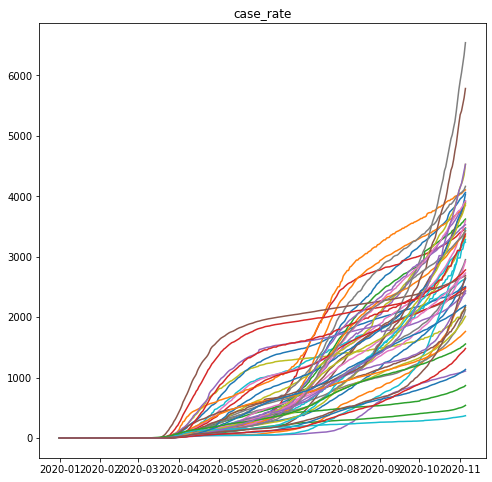

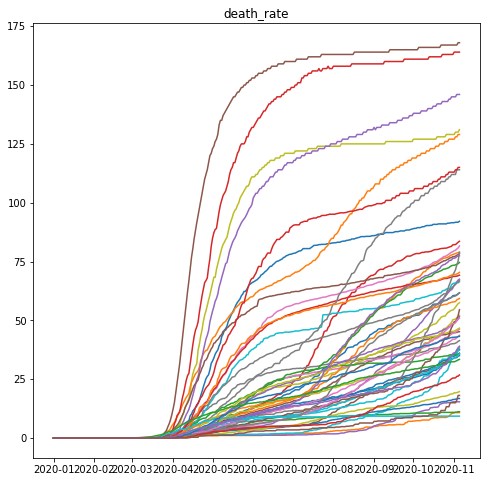

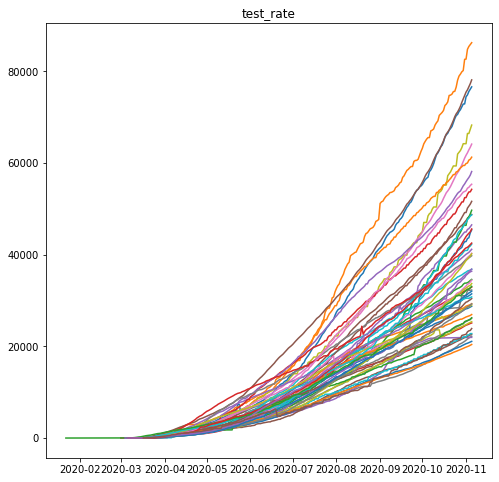

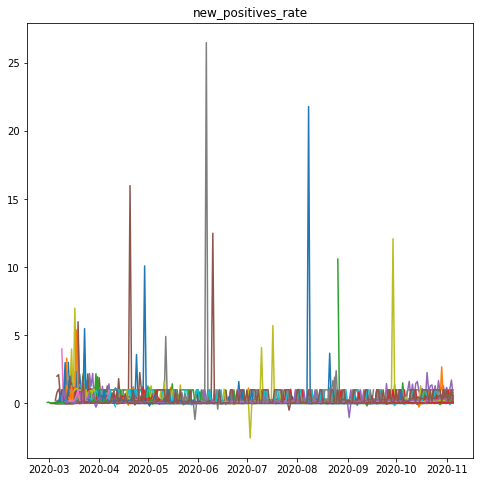

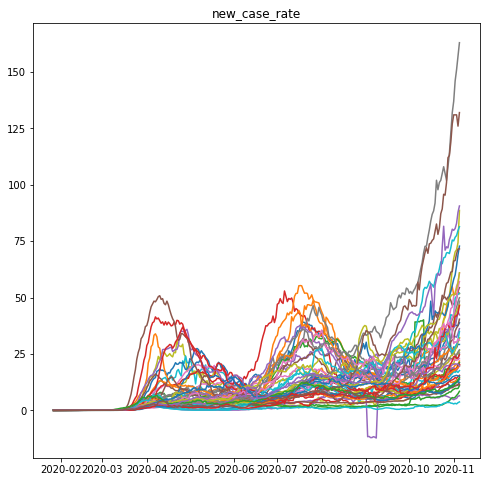

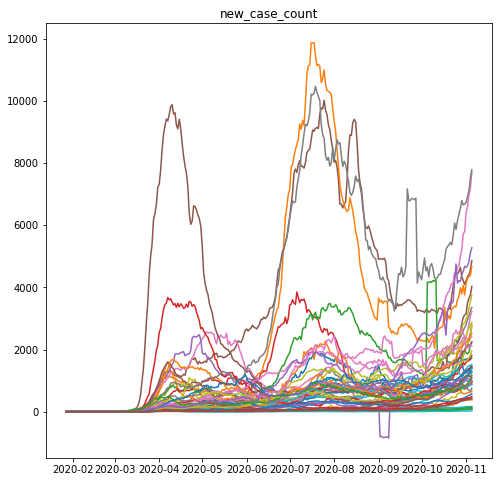

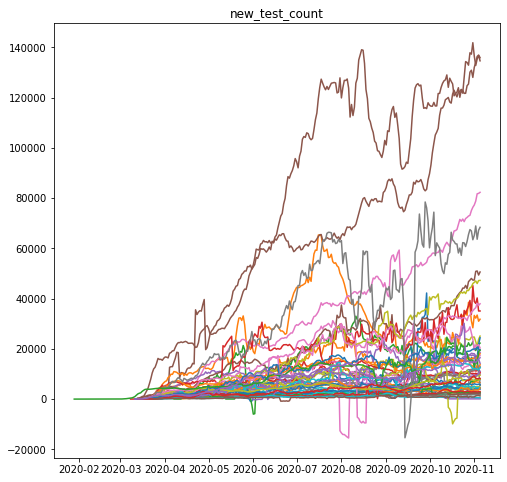

In [ ]:
# Drop January and November
df_scratch = df
# Drop cumulative COVID data (better to use rates/new counts)
df_scratch.drop(["case_count", "death_count", "test_count"], axis=1)

df_scratch['date'] = pd.to_datetime(df_scratch[['year','month','day']])

vars = ["case_rate", "death_rate", "test_rate", "new_positives_rate", "new_case_rate", "new_case_count", "new_test_count"]

for var in vars:
  plt.figure(figsize=(8,8))
  ax = plt.gca()
  for state in range(1,57):
    ax.set_xbound((pd.to_datetime("2020-01-01"), pd.to_datetime("2020-04-10")))
    plt.plot(df_scratch.loc[df_scratch["statefips"]==state, "date"], df_scratch.loc[df_scratch["statefips"]==state, var])
    plt.title(var)


#sns.lineplot(data=df_simple, x="date", y="case_rate", hue="statefips")

case_count  ...  new_test_count
days_since_2020Feb01 statefips              ...                
0                    1                   0  ...             0.0
                     2                   0  ...             0.0
                     4                   1  ...             0.0
                     5                   0  ...             0.0
                     6                   3  ...             0.0

[5 rows x 10 columns]

(13974, 10)
['case_count' 'death_count' 'test_count' 'case_rate' 'death_rate'
 'test_rate' 'new_positives_rate' 'new_case_count' 'new_death_count'
 'new_test_count']
LR: 1.000000 (0.000000)
NN: 0.000000 (0.000000)
KNN: 1.000000 (0.000000)
RF: 1.000000 (0.000000)
SVR: 1.000000 (0.000000)


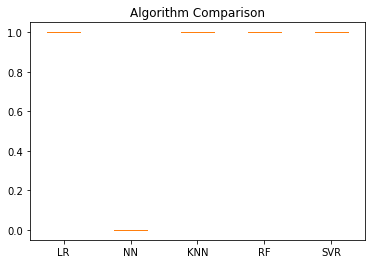

In [ ]:
df_temp = df_covid.copy()
#df_temp = df_temp.set_index('date')
# TH: Updated index name
df_temp = df_temp.set_index(['days_since_2020Feb01', 'statefips'])
# df_temp = df_temp.resample('W').mean()

data_case_rate = df_temp["new_case_rate"]
data_death_rate = df_temp["new_death_rate"]
data_test_rate = df_temp["new_test_rate"]

df_temp = df_temp.drop(columns=["new_case_rate", "new_death_rate", "new_test_rate"])

display(df_temp.head())
print(df_temp.shape)
print(df_temp.columns.values)

#X_train = df_temp[:'2020-09-27']
#y_train = data_death_rate[:'2020-09-27']
#X_test = df_temp['2020-10-04':]
#y_test = data_death_rate['2020-10-04':]

# I changed the date index above which messed up this filtering... sorry. 
# I don't know how to work with Pandas very well, can't figure out how to filter like what you were going for above
X_train = df_temp[:120]
y_train = data_death_rate[:120]
X_test = df_temp[127:]
y_test = data_death_rate[127:]

models = []
models.append(('LR', LinearRegression()))
models.append(('NN', MLPRegressor(solver = 'lbfgs')))
models.append(('KNN', KNeighborsRegressor())) 
models.append(('RF', RandomForestRegressor(n_estimators = 10)))
models.append(('SVR', SVR(gamma='auto')))

# Evaluate each model in turn
results = []
names = []
for name, model in models:
  tscv = TimeSeriesSplit(n_splits=10)
  cv_results = cross_val_score(model, X_train, y_train, cv=tscv, scoring='r2')
  results.append(cv_results)
  names.append(name)
  print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))
    
# Compare Algorithms
plt.boxplot(results, labels=names)
plt.title('Algorithm Comparison')
plt.show()


